In [1]:
from sklearn.datasets import load_boston
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn import datasets, linear_model
from sklearn import metrics, cross_validation
from sklearn.utils import shuffle

/Users/vijaypatel/miniconda3/envs/py34-learning/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


In [3]:
type(boston)

sklearn.datasets.base.Bunch

In [4]:
print(boston.DESCR)
print(boston.keys())
print(boston.feature_names)
print(boston.data.shape)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
X = boston.data

In [6]:
X[0:2, :]

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
          0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
          6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
          2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
          4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   6.42100000e+00,
          7.89000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.96900000e+02,
          9.14000000e+00]])

In [7]:
y = boston.target

In [8]:
y[0:2]

array([ 24. ,  21.6])

## Prepare train/test sets

In [9]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.33, random_state = 5)

print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (339, 13)
y_train shape: (339,)
X_test shape: (167, 13)
y_test shape: (167,)


## Define linear regression functions

In [10]:
def predict(X, theta):
    return X.dot(theta.T)

def sum_squared_error(y, y_pred):
    square_of_errors = np.square(y_pred - y)
    return np.sum(square_of_errors)

def mean_squared_error(y, y_pred):
    m = y.shape[0]
    return (1 / (m)) * sum_squared_error(y, y_pred)
    
def gradient(X, y, y_pred):
    m = X.shape[0]
    error = y_pred - y
    gradient = (1/m) * X.T.dot(error)
    return (gradient, error)
    
def gradient_descent_full_batch(X, y, theta, alpha, iterations):
    m = X.shape[0]
    for i in range(iterations):
        # Move in opposite direction to gradient, hence minus gradient.
        # Alpha seems to temper the gradient change, preventing huge swings. It should be low.
        y_pred = predict(X, theta)
        grad, error = gradient(X, y, y_pred)
        theta = theta - (alpha * grad)
        log_gradient_descent_step(i, theta, error)
            
    return theta

def gradient_descent_stochastic(X, y, theta, alpha, iterations):
    for i in range(iterations):
        X, y = shuffle(X, y, random_state=0)
        # theta is updated after calculating gradient for just one example
        # This is cheaper than calculating gradient across all examples, before adjusting theta \
        # especially where we have a huge number of examples
        for j, _ in enumerate(X):
            y_pred = predict(X, theta)
            grad, error = gradient(X[j], y[j], y_pred[j])
            theta = theta - (alpha * grad)
            
        log_gradient_descent_step(i, theta, error)
        
    return theta



## Define helper function

In [11]:
def plot_actual_over_predicted(y_actual, y_pred):
    plt.scatter(y_actual, y_pred)
    plt.plot([0, 50], [0, 50], '--k')
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
    plt.show()

def plot_residuals(X_train, y_train, X_test, y_test, theta):
    y_pred_for_X_train = predict(X_train, theta)
    y_pred_for_X_test = predict(X_test, theta)
    plt.scatter(y_pred_for_X_train, y_pred_for_X_train - y_train, c='b', s=40, alpha=0.5)
    plt.scatter(y_pred_for_X_test, y_pred_for_X_test - y_test, c='g', s=40)
    plt.hlines(y=0, xmin=0, xmax=50)
    plt.title('Residual plot using training (blue) and test (green) data')
    plt.ylabel('Residuals')
    plt.show()
    
def log_gradient_descent_step(it, theta, error):
     if (debug):
        print("Iteration: " + str(it))    
        print("  Theta: " + str(theta))
        print("  Error: " + str(error))
        
def calculate_cost_of_theta(X_train, y_train, X_test, y_test, theta):
    y_pred_for_X_train = predict(X_train, theta)
    y_pred_for_X_test = predict(X_test, theta)
    mse_on_train = mean_squared_error(y_train, y_pred_for_X_train)
    mse_on_test = mean_squared_error(y_test, y_pred_for_X_test)
    print('Theta: \n', theta)
    print("Mean squared error (train):", mse_on_train)
    print("Mean squared error (test):", mse_on_test)
        
def run_timed(func):
    start = time.clock()
    results = func()
    print("Time taken:", time.clock() - start)
    return results


## Test linear regression on limited data set

In [12]:
debug = True    

t_X = np.array([[1, 2, 3],[4, 5, 6]])
t_y = np.array([6, 15])
t_theta = np.array([2, 1, 1])
print("Theta: " + str(t_theta))

# Test cost function
t_y_pred = predict(t_X, t_theta)
cost = mean_squared_error(t_y, t_y_pred)
print("Cost: " + str(cost))
    
# Test gradient function
g, e = gradient(t_X, t_y, t_y_pred)
print("Gradient: " + str(g))

# Test gradient descent full batch
print("Testing gradient descent full batch")
t_initial_theta = np.array([4,3,2])
optimised_theta = gradient_descent_full_batch(t_X, t_y, t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

# Test gradient descent stochastic
print("Testing gradient descent stochastic")
optimised_theta = gradient_descent_stochastic(t_X, t_y, t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

Theta: [2 1 1]
Cost: 8.5
Gradient: [  8.5  11.   13.5]
Testing gradient descent full batch
Iteration: 0
  Theta: [ 3.39  2.2   1.01]
  Error: [10 28]
Iteration: 1
  Theta: [ 3.0535  1.7613  0.4691]
  Error: [  4.82  15.62]
Iteration: 2
  Theta: [ 2.866881   1.5205885  0.174296 ]
  Error: [ 1.9834  8.8351]
Iteration: 3
  Theta: [ 2.76240142  1.38837298  0.01434453]
  Error: [ 0.430946   5.1162425]
Iteration: 4
  Theta: [ 2.70293976  1.31561272 -0.07171431]
  Error: [-0.41781902  3.07753778]
Iteration: 5
  Theta: [ 2.66815391  1.27543408 -0.11728575]
  Error: [-0.88097773  1.95953678]
Iteration: 6
  Theta: [ 2.64689666  1.25311064 -0.14067537]
  Error: [-1.13283518  1.34607155]
Iteration: 7
  Theta: [ 2.63305945  1.24057253 -0.15191438]
  Error: [-1.26890816  1.00908763]
Iteration: 8
  Theta: [ 2.62329485  1.23339757 -0.15649972]
  Error: [-1.34153861  0.8236142 ]
Iteration: 9
  Theta: [ 2.61576852  1.22916243 -0.15744365]
  Error: [-1.37940918  0.72116891]
Iteration: 10
  Theta: [ 2.609

## Run Linear Regression From Scikit-learn

<b>Provides some results to compare against</b>

Coefficients: 
 [ -1.56381297e-01   3.85490972e-02  -2.50629921e-02   7.86439684e-01
  -1.29469121e+01   4.00268857e+00  -1.16023395e-02  -1.36828811e+00
   3.41756915e-01  -1.35148823e-02  -9.88866034e-01   1.20588215e-02
  -4.72644280e-01]
Mean squared error (train): 19.55
Mean squared error (test): 28.54


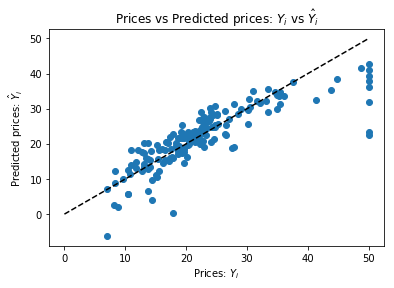

In [13]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print("Mean squared error (train): %.2f" % metrics.mean_squared_error(y_train, regr.predict(X_train)))
print("Mean squared error (test): %.2f" % metrics.mean_squared_error(y_test, y_pred))

plot_actual_over_predicted(y_test, y_pred)

## Run Linear Regression With Full Batch Gradient Descent

Theta: 
 [ 0.46648714  0.2873532   0.43186673  0.8831663   0.60400954  0.13952941
  0.24742888  0.04212565  0.08420083  0.45068029  0.3338288   0.4293077
  0.42441174]
Mean squared error (train): 131879.086546
Mean squared error (test): 133437.672728


Time taken: 9.177059999999999
Theta: 
 [-0.15027061  0.07297871 -0.05045502  0.93476827  0.73805953  3.3825108
  0.03511225 -0.52452163  0.17676659 -0.0079213   0.0660657   0.022421
 -0.57995773]
Mean squared error (train): 26.0253896787
Mean squared error (test): 34.8415491324


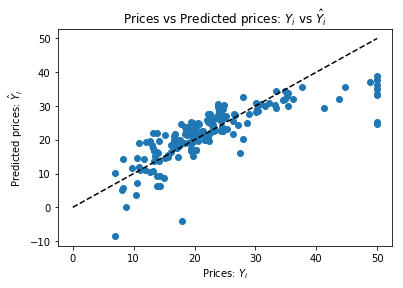

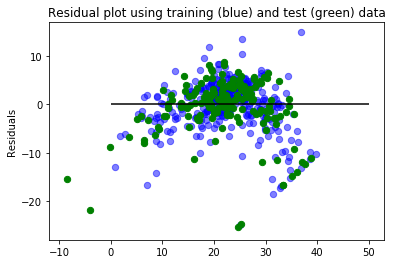

In [14]:
debug = False
num_of_iterations = 300000
alpha = 0.000004 # learning rate

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent_full_batch(X_train, y_train, initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)

## Run Linear Regression With Stochastic Gradient Descent

Theta: 
 [ 0.65326859  0.21220569  0.18246082  0.93481516  0.53548056  0.38227121
  0.28899866  0.05897516  0.22954969  0.81819864  0.70761516  0.94584898
  0.02203578]
Mean squared error (train): 499366.224711
Mean squared error (test): 501816.658608


Time taken: 8.335329999999999
Theta: 
 [-0.14182033  0.08283396 -0.05142802  0.97432246  0.63150663  2.65340539
  0.05080631 -0.40295436  0.16285082 -0.00629789  0.22668066  0.0217058
 -0.63749037]
Mean squared error (train): 29.3509711976
Mean squared error (test): 37.2813934058


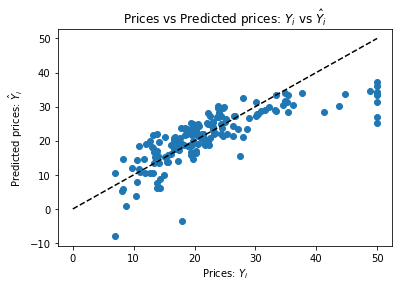

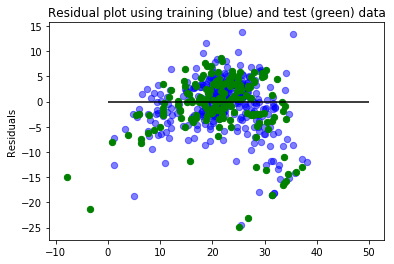

In [15]:
debug = False
num_of_iterations = 3000
alpha = 0.00001 # learning rate

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent_stochastic(X_train, y_train, initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)

Next steps:

- mini batch gradient descent
- Will feature scaling help?
- Can I incorporate a stopping condition?
- Can I reduce dimensions?